In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from PIL import Image

In [2]:
pretrained_net = torchvision.models.resnet18(pretrained=False)
fully_connected_net = nn.Sequential(*list(pretrained_net.children())[:-2])

num_classes = 21
fully_connected_net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
fully_connected_net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))

fully_connected_net.load_state_dict(torch.load('model_state.pt'))
fully_connected_net.eval()

c:\Users\Hayden\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hayden\anaconda3\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [3]:
devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

change_image = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((320, 480)),
    torchvision.transforms.ToTensor()
])

def predict(img):
    pred = fully_connected_net(img.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

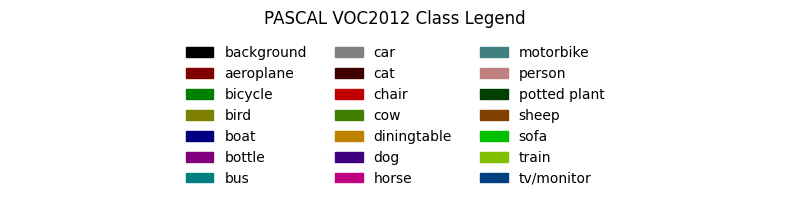

(333, 500, 3)
image opened


<Figure size 800x800 with 0 Axes>

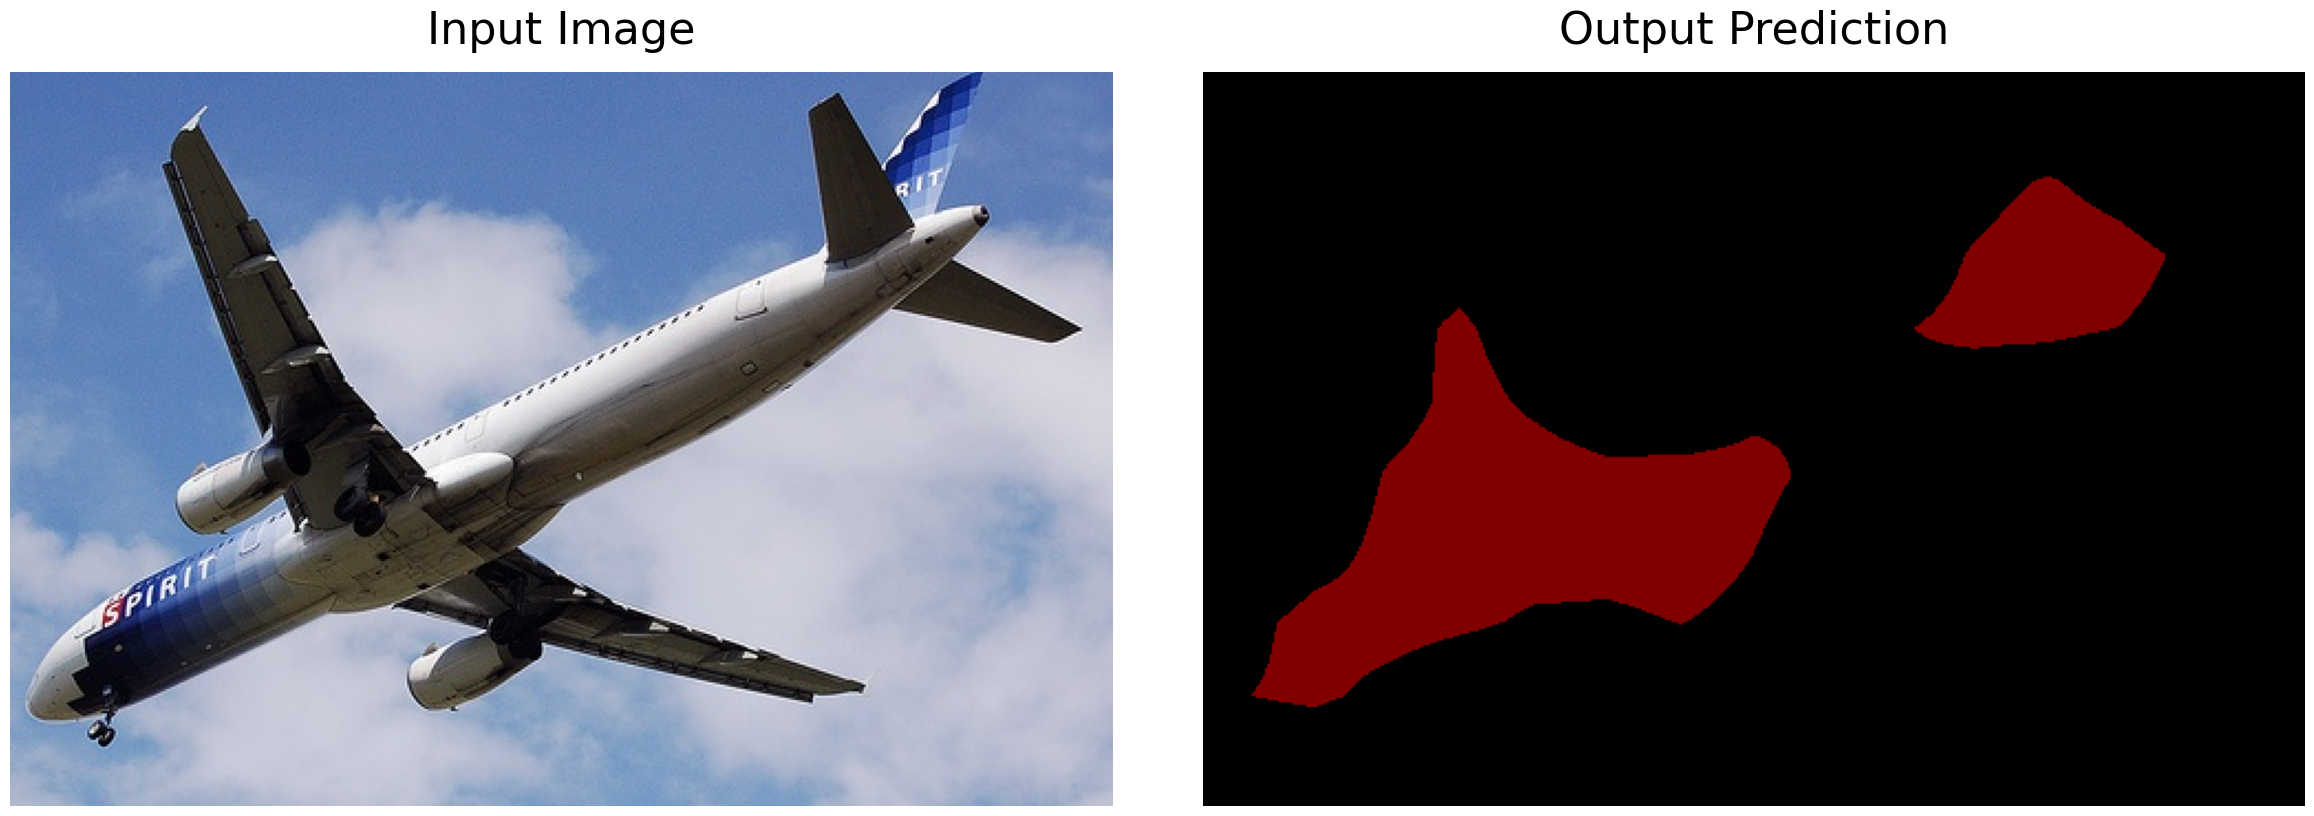

(333, 500, 3)
image opened


<Figure size 800x800 with 0 Axes>

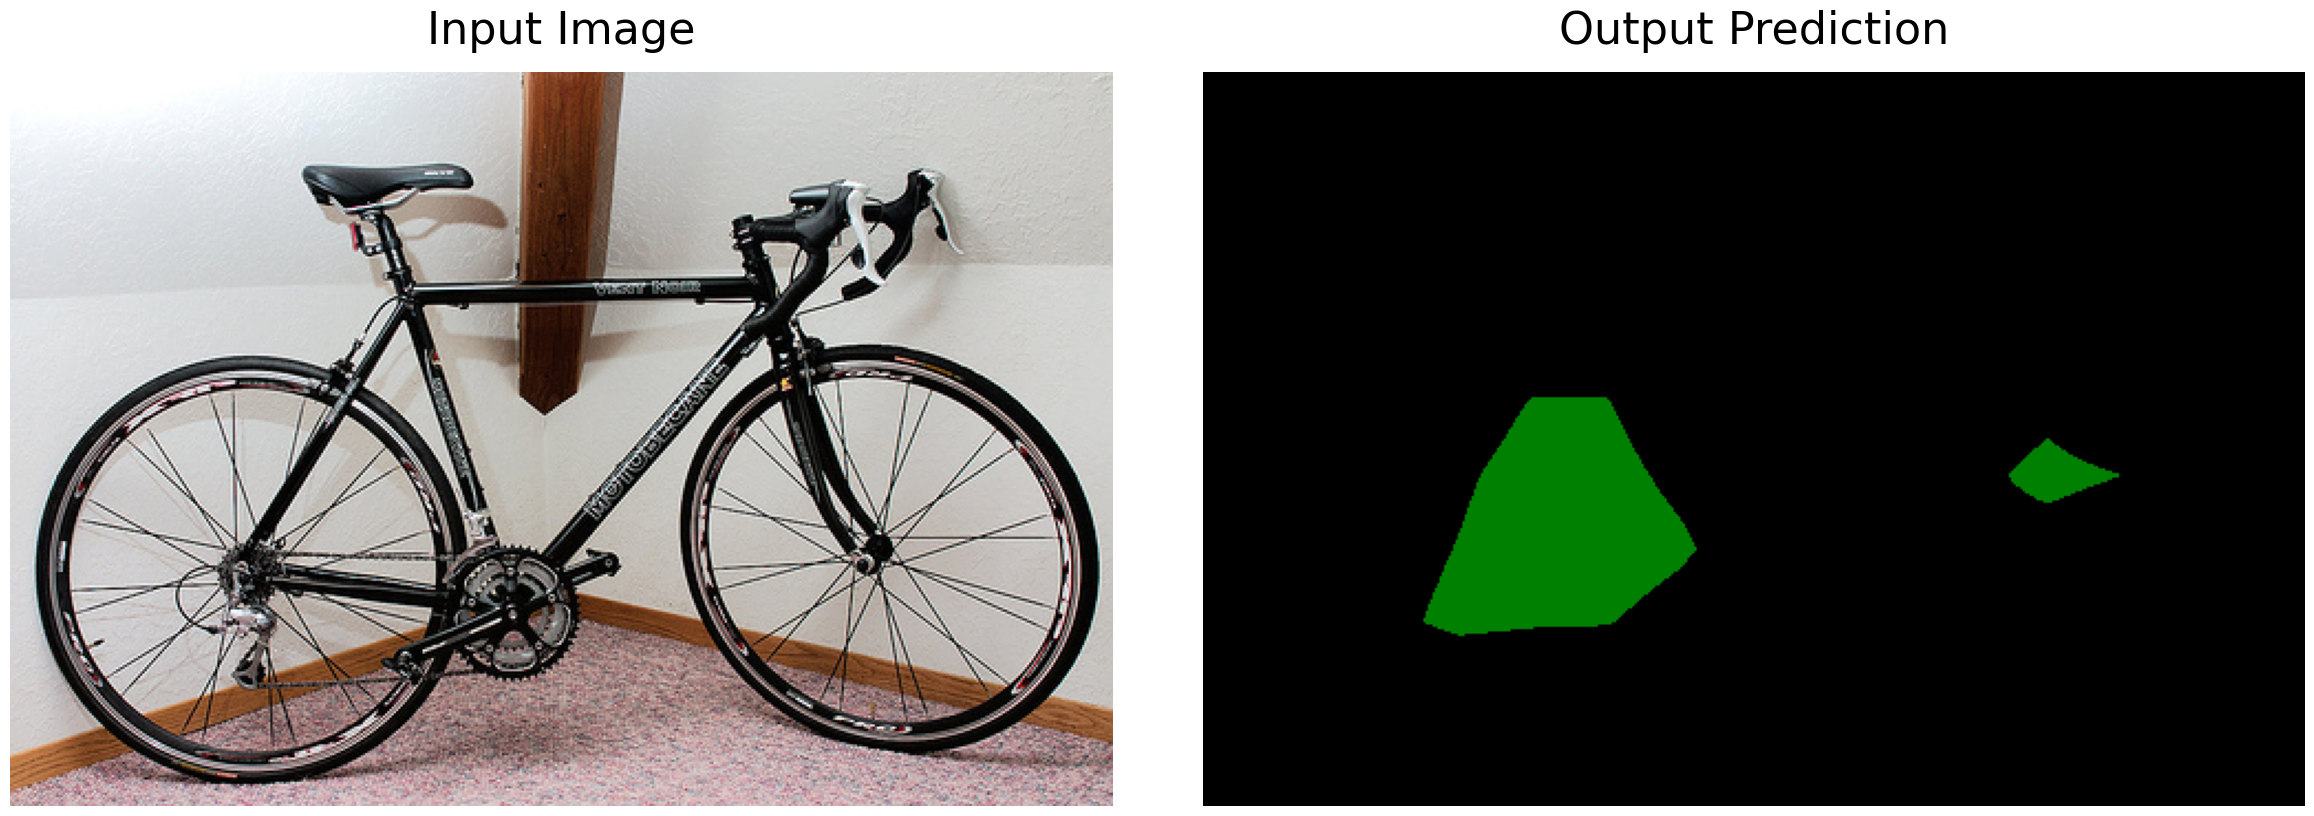

An error occurred. Ensure you have entered the correct path to the image file. Please try again. 
(375, 500, 3)
image opened


<Figure size 800x800 with 0 Axes>

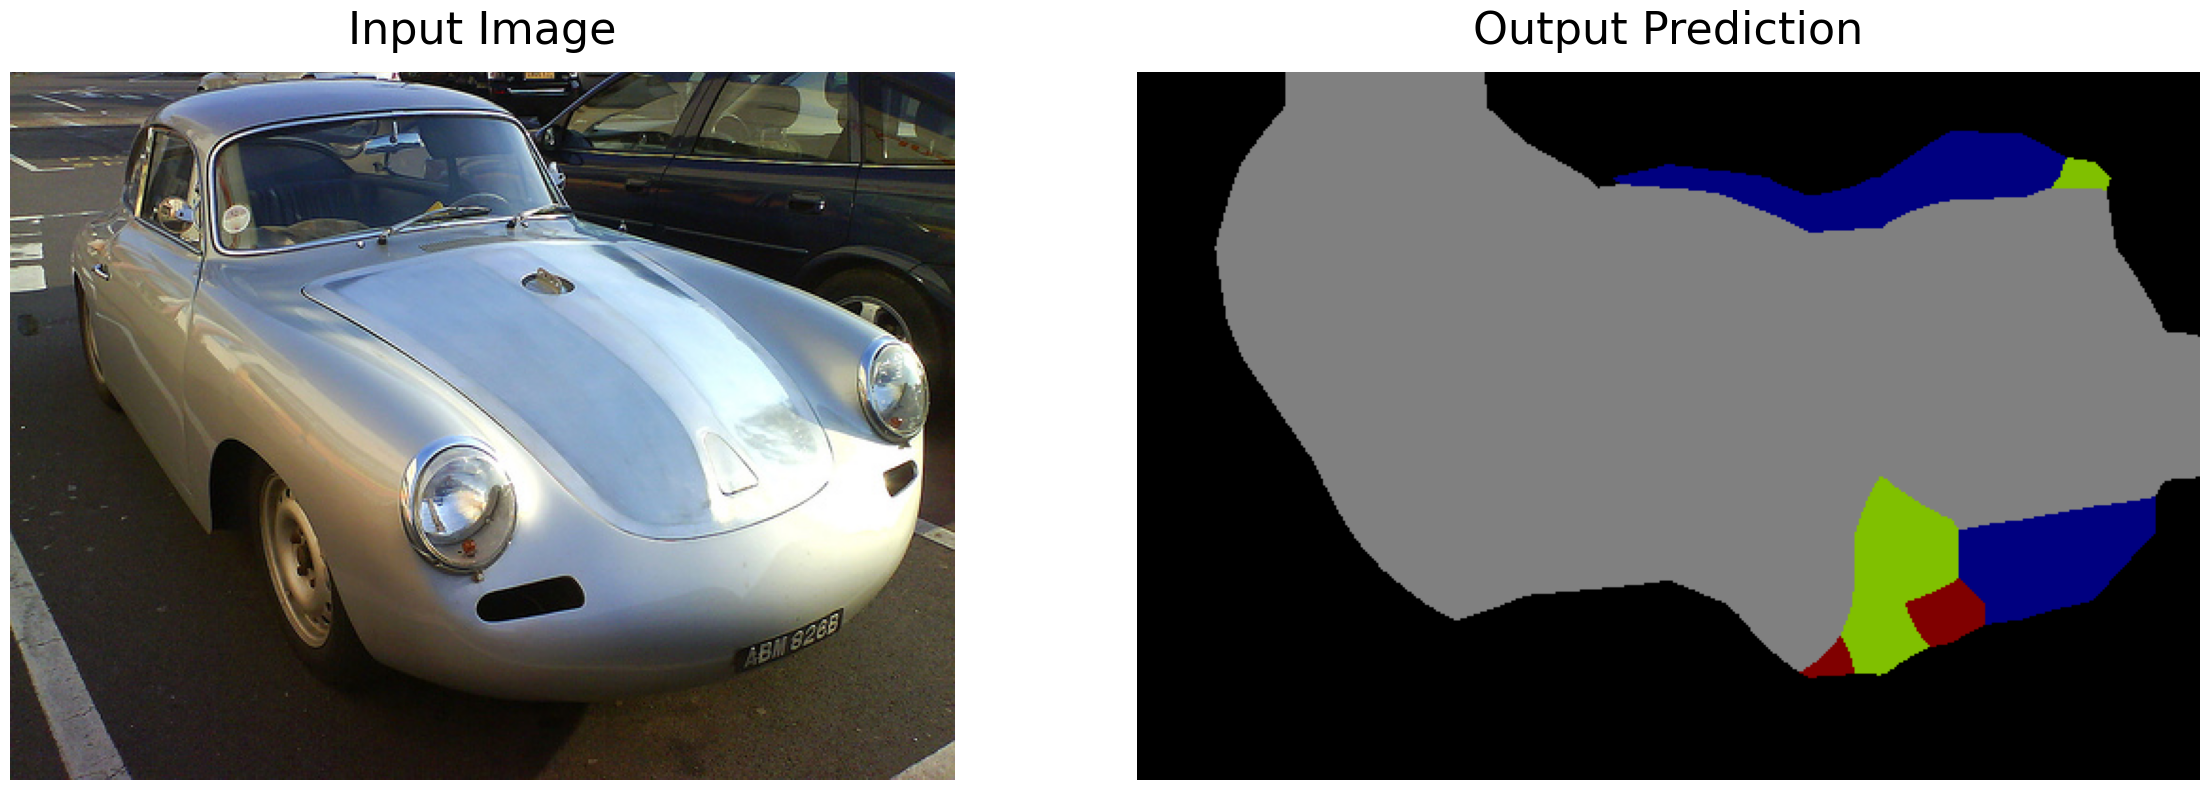

(334, 500, 3)
image opened


<Figure size 800x800 with 0 Axes>

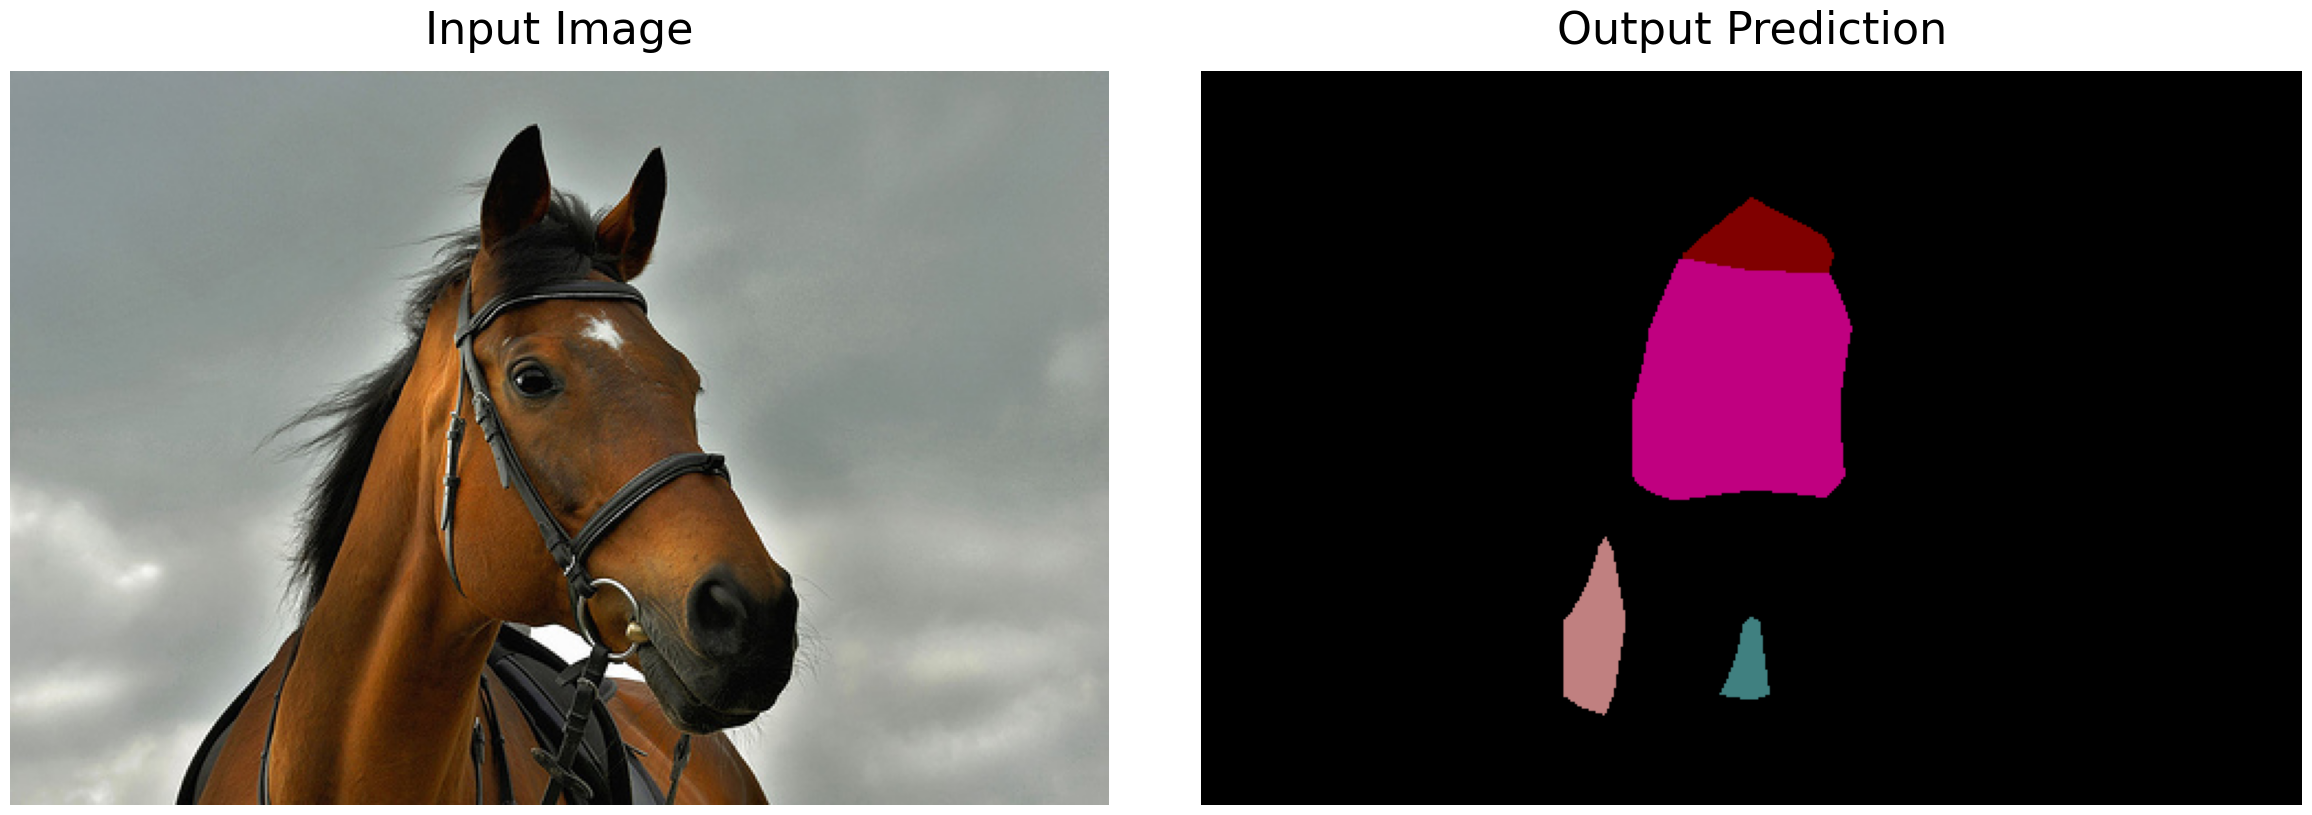

(375, 500, 3)
image opened


<Figure size 800x800 with 0 Axes>

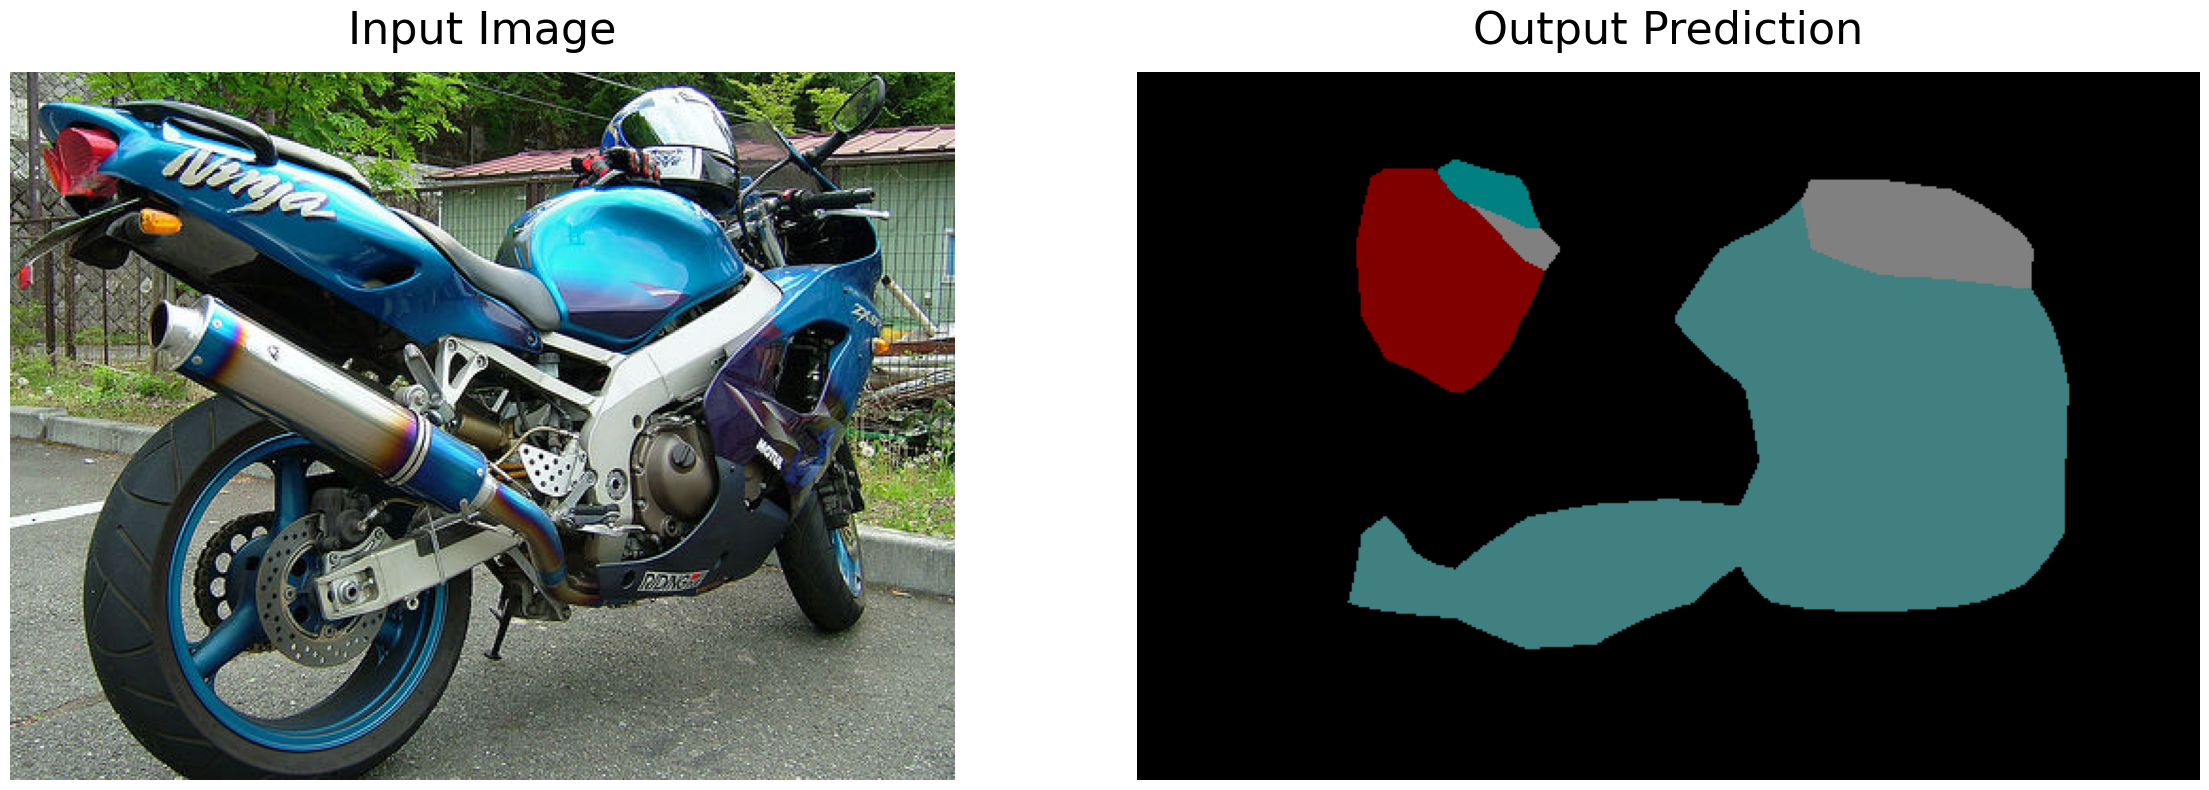

(375, 500, 3)
image opened


<Figure size 800x800 with 0 Axes>

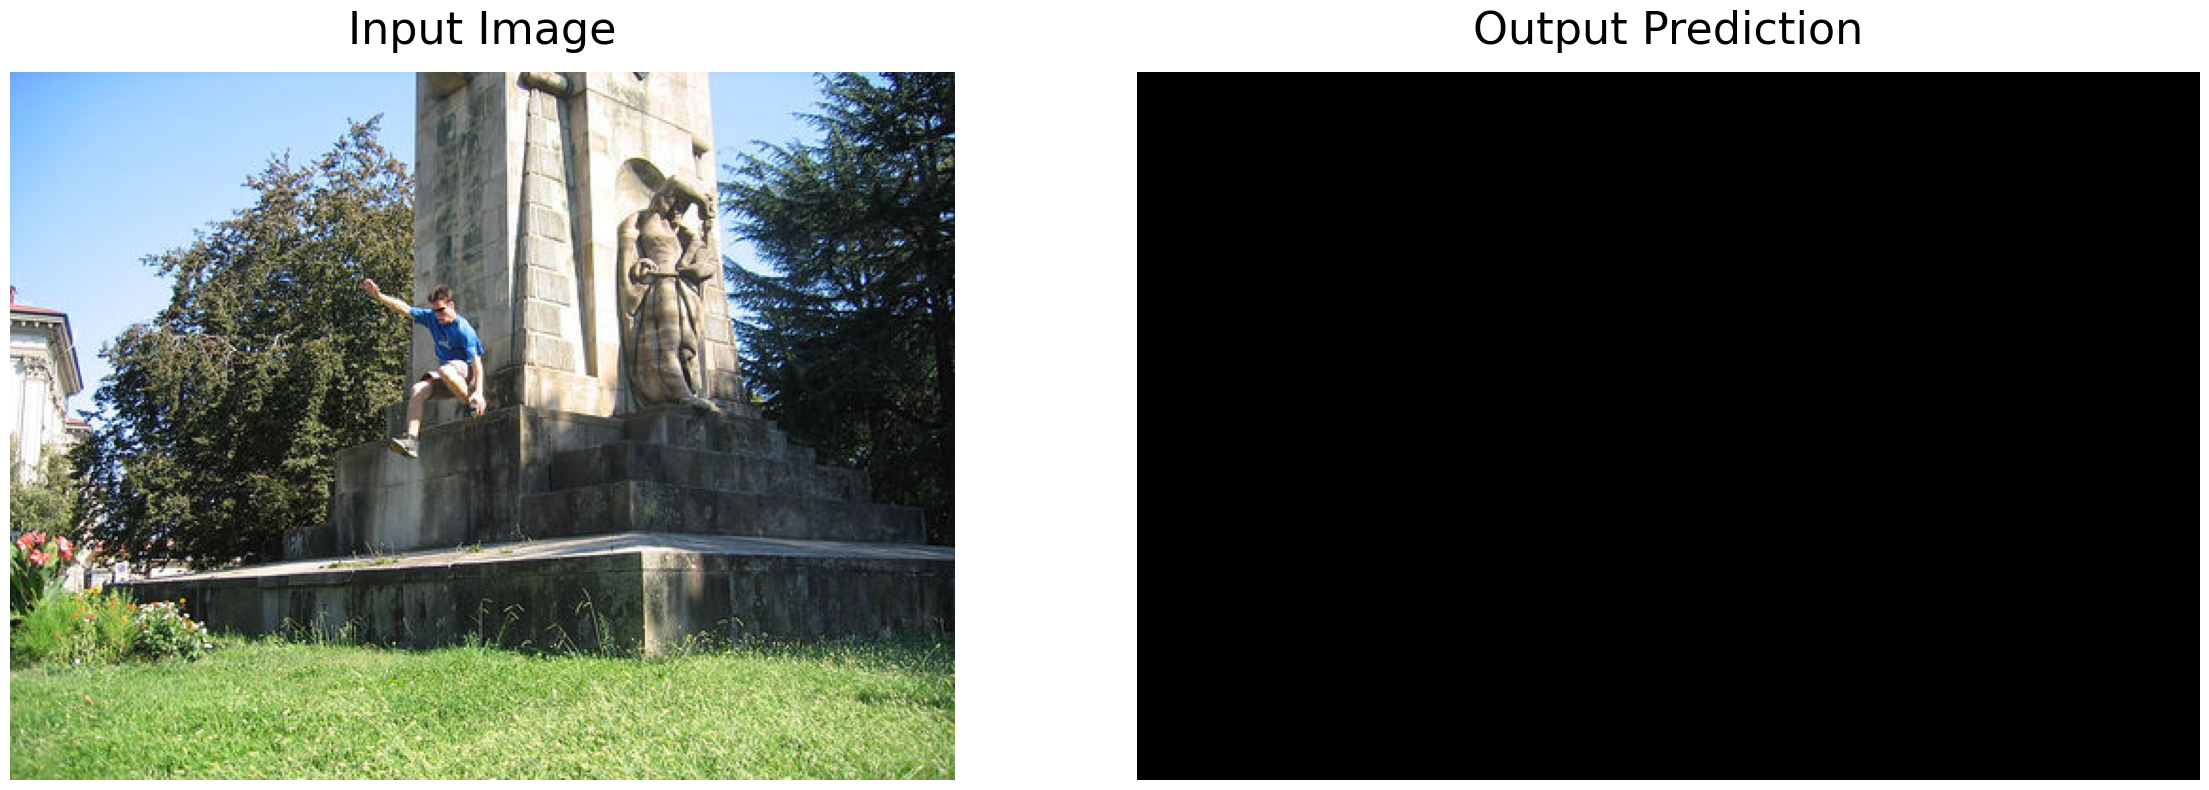

An error occurred. Ensure you have entered the correct path to the image file. Please try again. 


In [4]:
legend_patches = [
    Patch(color=[c / 255.0 for c in rgb], label=cls_name)
    for rgb, cls_name in zip(VOC_COLORMAP, VOC_CLASSES)
]
fig = plt.figure(figsize=(8, 2))
plt.legend(handles=legend_patches, ncol=3, loc='center', frameon=False)
plt.axis('off')
plt.title("PASCAL VOC2012 Class Legend", pad=20)
plt.tight_layout()
plt.show()

input_file = None
rows, cols = 2, 3
while input_file is None or input_file != 'exit':
    try:
        image_list = []
        input_file = input('Please enter a file path or type "exit" to quit:\n')
        if input_file == 'exit':
            break
        img = Image.open(input_file)
        print(np.array(img).shape)
        print('image opened')

        with torch.no_grad():
            output = fully_connected_net(change_image(img).unsqueeze(0)).argmax(dim=1)
        
        figure = plt.figure(figsize=(8, 8))
        image_list.append(img)

        prediction = label2image(output.reshape(output.shape[1], output.shape[2]))
        prediction = prediction.cpu().numpy()
        image_list.append(prediction)

        figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(4 * rows * cols, 8))
        axes[0].imshow(image_list[0])
        axes[0].axis('off')
        axes[0].set_title('Input Image', fontsize=32, pad=20)
        axes[1].imshow(image_list[1])
        axes[1].axis('off')
        axes[1].set_title('Output Prediction', fontsize=32, pad=20)
        plt.tight_layout()
        plt.show()

    except:
        print('An error occurred. Ensure you have entered the correct path to the image file. Please try again. ')
